In [ ]:
import os
import keras
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from keras.preprocessing. image import ImageDataGenerator
import plotly.express as px
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras import layers
from keras.layers import Dense, Activation, Flatten
from keras.callbacks import EarlyStopping as ES, ModelCheckpoint as MC
import glob as gb
import seaborn as sns
import cv2
from keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.preprocessing.image import img_to_array


: 

In [20]:
gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    brightness_range=[0.3,0.8],
    validation_split=0.1
)

In [21]:
tpath=os.getcwd()
tpath=os.path.join(tpath,"train")
training_data= keras.preprocessing.image_dataset_from_directory(
    tpath,
    batch_size = 10,
    image_size =(351,351),
    
    shuffle = True,
    seed =123,
    validation_split =0.2,
    subset ='training'
)

Found 2339 files belonging to 10 classes.
Using 1872 files for training.


In [22]:
vpath=os.getcwd()
vpath=os.path.join(vpath,"valid")
validation_data= keras.preprocessing.image_dataset_from_directory(
    vpath,
    batch_size = 10,
    image_size =(351,351),
    
    shuffle = True,
    seed =123,
    validation_split =0.2,
    subset ='validation'
)

Found 50 files belonging to 10 classes.
Using 10 files for validation.


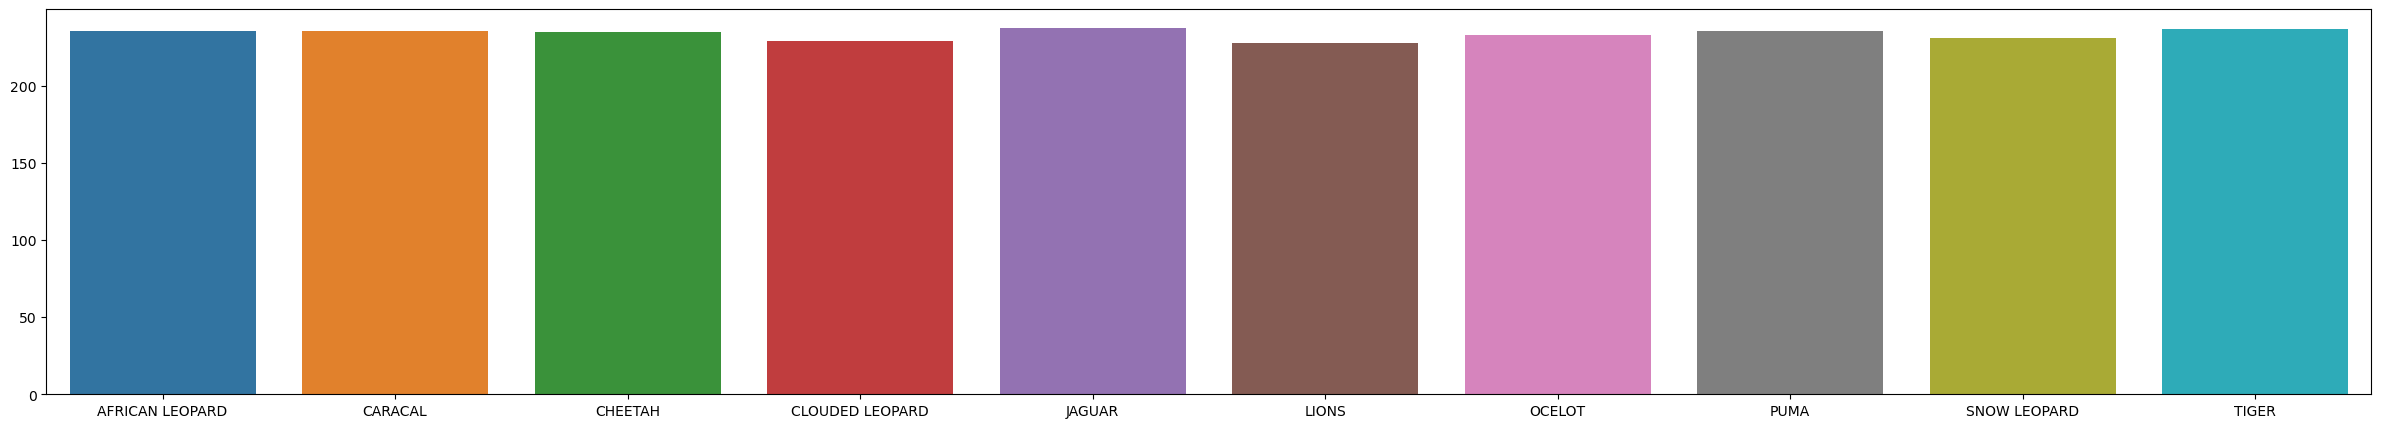

In [24]:
class_names = [ ]
class_count = [ ]
train_examples = 0
for f in os.listdir(tpath):
    files = gb.glob(pathname=str(tpath +"//"+f+"/*"))
    class_names.append(f)
    class_count.append(len( files))
    train_examples += len(files)
plt.figure(figsize=(30,5) )
sns.barplot(x=class_names,y=class_count)
plt.show( )

In [25]:
class_names

['AFRICAN LEOPARD',
 'CARACAL',
 'CHEETAH',
 'CLOUDED LEOPARD',
 'JAGUAR',
 'LIONS',
 'OCELOT',
 'PUMA',
 'SNOW LEOPARD',
 'TIGER']

Found 2339 images belonging to 10 classes.


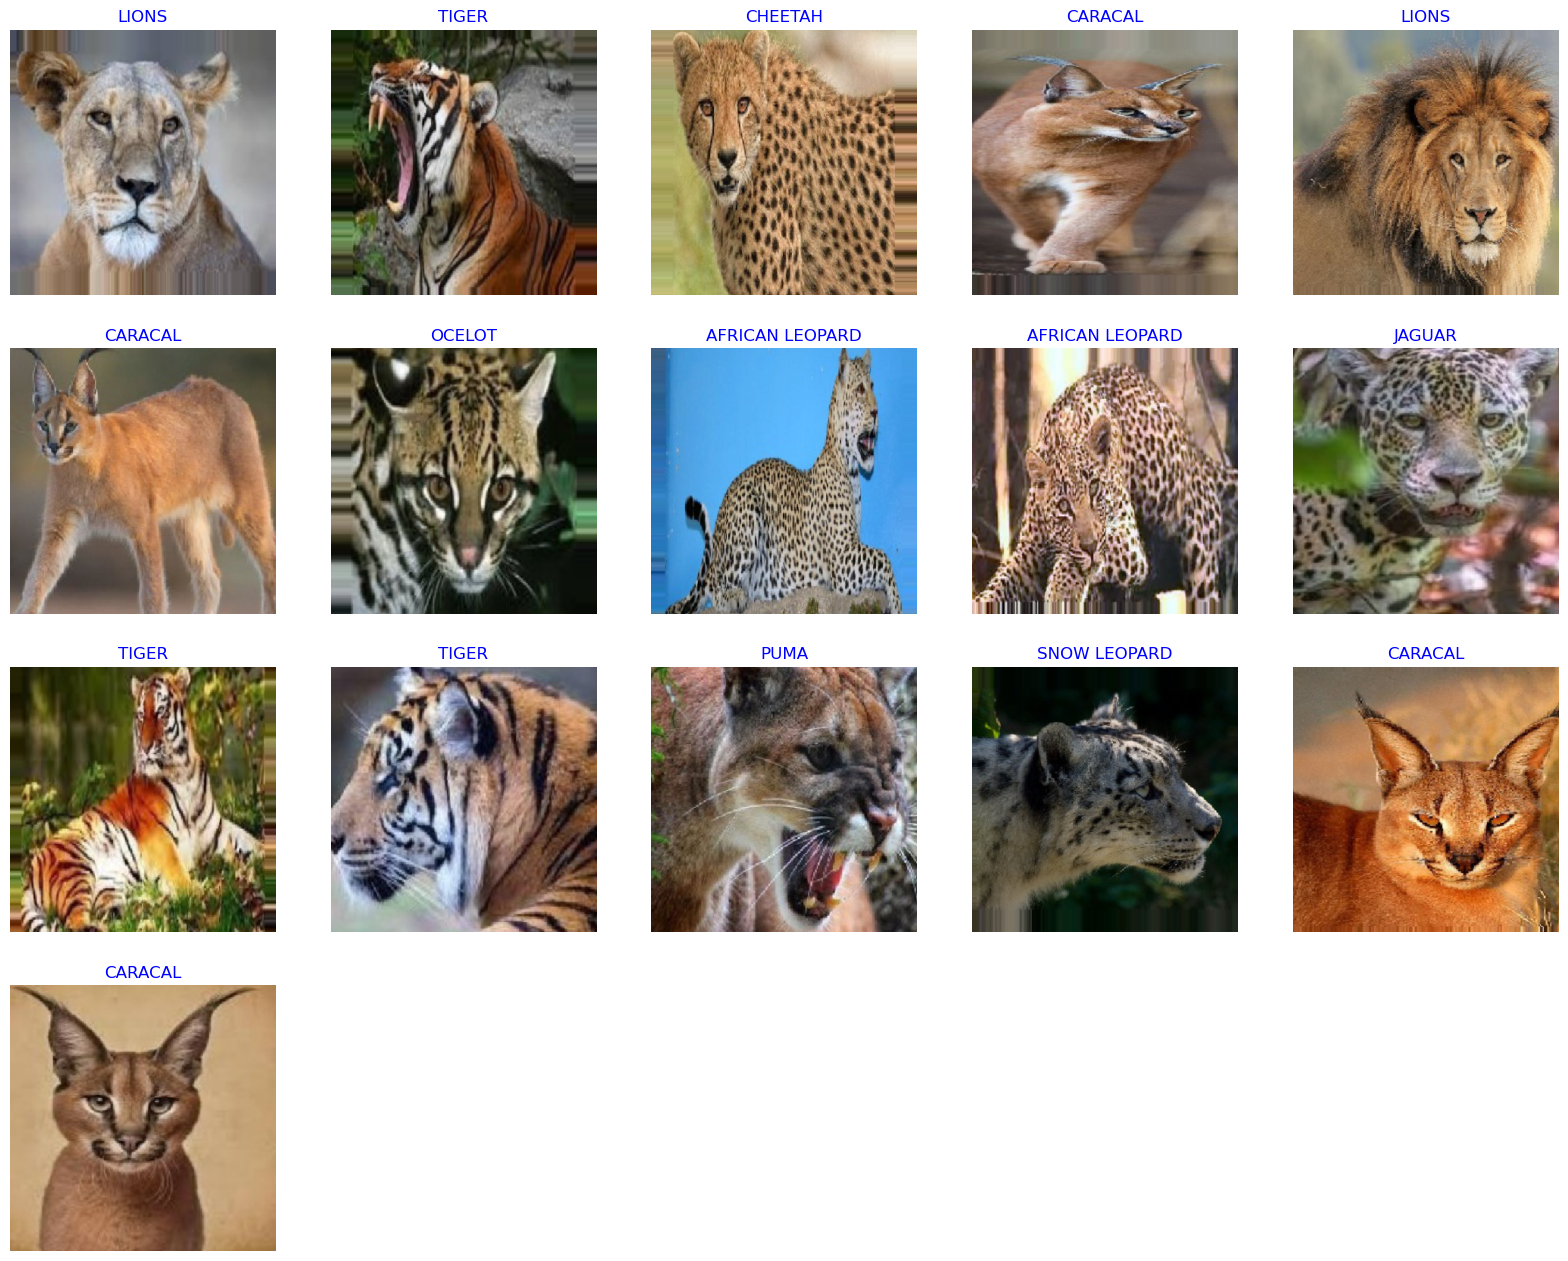

In [26]:
train_gen=ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True ,
    validation_split=0.2
)
train_batch=train_gen.flow_from_directory(
    directory=tpath,
    target_size=(351, 351 ),
    batch_size=16,
)
g_dict = train_batch.class_indices
classes=list(g_dict.keys())
images, labels = next(train_batch)


length= len(labels)
sample = min(length, 30)
plt.figure(figsize=(20, 20))
for i in range(sample) :
    plt.subplot(5, 5, i + 1)
    image=images[i]
    plt.imshow ( image)
    index=np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='blue',fontsize= 12)
    plt.axis('off')
plt.show( )

In [27]:
resnet_model=Sequential()
pretrained_model=keras.applications.ResNet50(include_top=False,
                                             input_shape=(351,351,3),
                                             pooling='avg',
                                             classes=23,
                                             weights='imagenet' )
for layer in pretrained_model.layers:
    layer.trainable=False
resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(1024,activation='relu'))
resnet_model.add(Dense(23,activation='softmax'))

In [28]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 23)                23575     
                                                                 
Total params: 25709463 (98.07 MB)
Trainable params: 2121751 (8.09 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [29]:
resnet_model.compile(optimizer='Adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

In [30]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = resnet_model.fit(training_data, epochs=35, validation_data=validation_data, callbacks=[tensorboard_callback])

Epoch 1/35


188/188 [==============================] - 190s 987ms/step - loss: 0.8062 - accuracy: 0.7543 - val_loss: 0.5879 - val_accuracy: 0.9000
Epoch 2/35
188/188 [==============================] - 199s 1s/step - loss: 0.2570 - accuracy: 0.9129 - val_loss: 0.4624 - val_accuracy: 0.9000
Epoch 3/35
188/188 [==============================] - 197s 1s/step - loss: 0.1734 - accuracy: 0.9386 - val_loss: 0.3270 - val_accuracy: 0.9000
Epoch 4/35
188/188 [==============================] - 206s 1s/step - loss: 0.1340 - accuracy: 0.9514 - val_loss: 0.2451 - val_accuracy: 0.9000
Epoch 5/35
188/188 [==============================] - 201s 1s/step - loss: 0.1081 - accuracy: 0.9610 - val_loss: 0.2935 - val_accuracy: 0.9000
Epoch 6/35
188/188 [==============================] - 204s 1s/step - loss: 0.0854 - accuracy: 0.9701 - val_loss: 0.2768 - val_accuracy: 0.9000
Epoch 7/35
188/188 [==============================] - 201s 1s/step - loss: 0.1125 - accuracy: 0.9594 - val_loss: 0.3821 - val_accuracy: 0

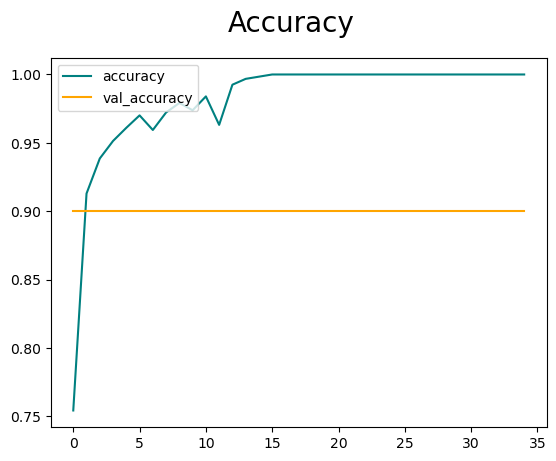

In [31]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [32]:
resnet_model.save(os.path.join('models','final.h5'))

C:\Users\nihar\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

testpath = os.getcwd()
testpath = os.path.join(testpath, "test")
subfolders = [f.path for f in os.scandir(testpath) if f.is_dir()]
class_names = ['African Leopard', 'Caracal', 'Cheetah', 'Clouded Leopard', 'Jaguar', 'Lions', 'Ocelot', 'Puma', 'Snow Leopard', 'Tiger']
true_labels = []
predicted_labels = []

for folder in subfolders:
    image_files = [f.path for f in os.scandir(folder) if f.is_file() and f.name.endswith(('.jpg', '.jpeg', '.png'))]
    for img_path in image_files:
        img = image.load_img(img_path, target_size=(351, 351))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        predictions = resnet_model.predict(x)
        class_idx = np.argmax(predictions, axis=1)[0]
        true_label = class_names.index(os.path.basename(folder).title())       
        predicted_labels.append(class_idx)
        true_labels.append(true_label)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
classification_report_str = classification_report(true_labels, predicted_labels, target_names=class_names)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f'Accuracy: {accuracy}')
print('\nConfusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(classification_report_str)


1/1 [==============================] - 0s 181ms/step
Accuracy: 0.86

Confusion Matrix:
[[4 0 0 0 1 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 1 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [1 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [1 0 0 1 0 0 2 0 0 1]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 1 0 0 0 0 4 0]
 [0 0 0 0 0 0 0 0 0 5]]

Classification Report:
                 precision    recall  f1-score   support

African Leopard       0.67      0.40      0.50         5
        Caracal       1.00      1.00      1.00         5
        Cheetah       0.83      1.00      0.91         5
Clouded Leopard       0.83      1.00      0.91         5
         Jaguar       0.67      0.80      0.73         5
          Lions       1.00      1.00      1.00         5
         Ocelot       1.00      0.40      0.57         5
           Puma       1.00      1.00      1.00         5
   Snow Leopard       0.83      1.00      0.91         5
          Tiger       0.83      1.00      0.91         5

       accuracy              